In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [3]:
politics = pd.read_csv("./final_csvs/politics.csv", index_col = 0)
money = pd.read_csv("./final_csvs/money.csv", index_col = 0)
sports = pd.read_csv("./final_csvs/sports.csv", index_col = 0)
tech = pd.read_csv("./final_csvs/tech.csv")

In [4]:
len(money), len(sports), len(tech)

(1779, 2588, 4122)

In [5]:
sports.columns

Index(['url', 'title', 'author', 'published', 'claps', 'text', 'tags',
       'duration', 'username'],
      dtype='object')

In [6]:
#there was a bug with the webscraping: people with 2020 claps have the wrong number of claps. 
#checked via website, having differing number of claps
politics = politics[politics.claps != 2020]

#get ratio of clap to followers, put as a new feature
clap_ratio = politics.claps / politics.followers

#get number of followers:
followers = politics.followers

#put the clap ratio as a new feature
politics["clap_ratio"] = clap_ratio

In [7]:
politics.head()

,url,title,author,username,user_since,following,followers,published,claps,text,tags,clap_ratio
0,https://medium.com/@lizardgrey/lets-pass-on-th...,"Let’s Pass on the Pizzazz, NBC, and Listen to ...",Elizabeth Grey,medium.com/@lizardgrey,2019.0,82.0,57.0,Nov 14,22,"['[Photo courtesy of Pixabay, There is a diffe...","['Politics', 'Impeachment', 'Ukraine', 'Diplom...",0.385965
1,https://medium.com/swlh/politics-isnt-my-passi...,Politics Isn’t My Passion,Elizabeth Grey,medium.com/@lizardgrey,2019.0,82.0,57.0,Nov 12,103,"['[image courtesy of Pixabay, Last night I was...","['Top ', 'Story', 'Submit, ', 'Politics', 'Tru...",1.807018
2,https://medium.com/@lizardgrey/my-no-lies-diet...,The No More Lies Diet Book,Elizabeth Grey,medium.com/@lizardgrey,2019.0,82.0,57.0,Nov 10,2,['[I can’t write about politics today. It’s to...,"['Weight ', 'Loss', 'Self ', 'Improvement', 'E...",0.035088
3,https://medium.com/the-slowdown/how-likely-is-...,How Likely is a Real-life Terminator?,Amie Haven,medium.com/@amiehaven,2019.0,17.0,21.0,Nov 14,104,['[Lethal autonomous weapon systems (LAWS) are...,"['About', 'Pitch ', 'Us ', 'Slalom, ', 'Artifi...",4.952381
4,https://medium.com/@lizardgrey/lets-pass-on-th...,"Let’s Pass on the Pizzazz, NBC, and Listen to ...",Elizabeth Grey,medium.com/@lizardgrey,2019.0,82.0,57.0,Nov 14,22,"['[Photo courtesy of Pixabay, There is a diffe...","['Politics', 'Impeachment', 'Ukraine', 'Diplom...",0.385965


## NLP

In [8]:
import random

making train and test set:

In [9]:
#politics has empty text tags
politics = politics[~(politics.text == '[]')]
money = money[~(money.text == '[]')]
sports = sports[~(sports.text == '[]')]
tech = tech[~(tech.text == '[]')]

take subset nan values !

In [10]:
#down sample
np.random.seed = 42
pol = politics.sample(2000, replace= False)[["text"]].reset_index(drop=True)
mon = money.sample(len(money), replace = False)[["text"]].reset_index(drop=True)
spo = sports.sample(len(sports), replace = False)[["text"]].reset_index(drop=True)
tec = tech.sample(2000, replace = False)[["text"]].reset_index(drop=True)

In [11]:
#adding on the labels:
pol["label"] = [0] * len(pol)
mon["label"] = [1] * len(mon)
spo["label"] = [2] * len(spo)
tec["label"] = [3] * len(tec)

In [12]:
#need to split them up to train and test
len_mon = len(mon)
len_pol = len(pol)
len_tec = len(tec)
len_spo = len(spo)

In [13]:
len_mon, len_pol, len_tec, len_spo

(1647, 2000, 2000, 2588)

In [14]:
#need to get train set
len_train_mon = int(len_mon * .80)
len_train_pol = int(len_pol * .80)
len_train_tec = int(len_tec * .80)
len_train_spo = int(len_spo * .80)

In [15]:
#train sets
train_mon = mon.iloc[:len_train_mon]
train_pol = pol.iloc[:len_train_pol]
train_tec = tec.iloc[:len_train_tec]
train_spo = spo.iloc[:len_train_spo]

#test sets
test_mon = mon.iloc[len_train_mon:]
test_pol = pol.iloc[len_train_pol:]
test_tec = tec.iloc[len_train_tec:]
test_spo = spo.iloc[len_train_spo:]

In [39]:
#need to combine all categories together for train
mp = pd.concat([train_mon, train_pol], axis = 0)
ts = pd.concat([train_tec, train_spo], axis = 0)
train = pd.concat([mp,ts],axis=0)

#need to combine all categories together for test
mp_ = pd.concat([test_mon, test_pol], axis = 0)
ts_ = pd.concat([test_tec, test_spo], axis = 0)
test = pd.concat([mp_,ts_],axis=0)

In [40]:
train = train.sample(frac = 1, replace = False).reset_index(drop=True)
test = test.sample(frac = 1, replace = False).reset_index(drop=True)

In [41]:
train.head()

,text,label
0,Enough with all the rookie talk! Luka Doncic h...,2
1,“Road is dead.” So goes the morose refrain fro...,2
2,['[I teach progressives how to communicate mor...,0
3,"['[By YiLi Chien and Qiuhan Sun, How do Americ...",1
4,Last year the New Orleans Pelicans lived two d...,2


In [42]:
sum(pd.isnull(train["text"]))
sum(pd.isnull(test["text"]))

27

In [43]:
#get rid of null values
train = train[~pd.isnull(train["text"])]
test = test[~pd.isnull(test["text"])]
#get X and Y data
all_words = train.text
Y_training = train.label

all_words_text = test.text
Y_test_orig = test.label


In [44]:
#create the vector
#focus on max_features as well
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = 50)

#fit the data
vector.fit(all_words)

#can look at the vectorizer
print(vector.get_feature_names())

['000', 'american', 'best', 'better', 'change', 'day', 'did', 'does', 'dont', 'financial', 'game', 'going', 'good', 'government', 'home', 'im', 'income', 'just', 'know', 'life', 'like', 'long', 'make', 'market', 'money', 'need', 'new', 'pay', 'people', 'political', 'president', 'right', 'said', 'say', 'state', 'states', 'team', 'thats', 'things', 'think', 'time', 'trump', 'use', 'want', 'way', 'work', 'world', 'year', 'years', 'youre']


In [45]:
#transforming the data, aka manipulating it based on the weights we 
#determined before by fitting our data 
train_trans = vector.transform(all_words)

In [23]:
train_trans

<6496x50 sparse matrix of type '<class 'numpy.float64'>'
	with 88505 stored elements in Compressed Sparse Row format>

In [25]:
#create the model (look at the documentation to see if there's any 
# parameters) you should pay closer attention to.

#this is how you create a basic decision tree
dt = DecisionTreeClassifier(max_depth = 10)

#cross validation:
scores = cross_validate(dt, train_trans, Y_training, cv = 5)

#fit the model, use your train data
#dt.fit(train_trans, Y_train)

In [26]:
#these scores are a very basic baseline model (without any hyperparameter tuning)
scores

{'fit_time': array([0.40595078, 0.43679118, 0.40092635, 0.35006738, 0.37699175]),
 'score_time': array([0.00299048, 0.00199652, 0.00299311, 0.0019958 , 0.00199509]),
 'test_score': array([0.7217525 , 0.73230769, 0.72517321, 0.73420647, 0.71109399])}

### Hyperparameter tuning:
https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
tuning hyperparameters listed above in this article. 
(could use hyperopt or grid search, but would take too long).

In [27]:
from sklearn.model_selection import KFold

In [ ]:
#doing grid search
clf = GridSearchCV(dt, parameters, cv = 3)

In [ ]:
#dict to keep my results:
tuning_dict = {}
i = 0
#a makeshift gridsearch:
for max_depth_i in range(8, 16):
    for min_sample_splits_i in np.arange(.01, 0.22, .1):
        i = i + 1
        print(i)
        #this is how you create a basic decision tree
        dt = DecisionTreeClassifier(
            max_depth = max_depth_i)
        #making vectorizer:
        vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = 100)


        #cross validation:
        kfold = KFold(n_splits = 3)
        for train_index, test_index in kfold.split(train):
            #split into train and test:
            X_train, X_test = train["text"].iloc[train_index], train['text'].iloc[test_index]
            Y_train, Y_test = train["label"].iloc[train_index], train['label'].iloc[test_index]

            #fit vectorizer on the train data:
            X_train_trans = vector.fit_transform(X_train)

            #DO NOT refit it onto the test data!
            X_test_trans = vector.transform(X_test)

            #fit on the decision tree
            dt.fit(X_train_trans, Y_train)
            test_scores = dt.score(X_test_trans, Y_test)
            train_scores = dt.score(X_train_trans, Y_train)

            #add to the dictionary

            tuning_dict[i] = {"train": np.mean(train_scores), "test":np.mean(test_scores), "params":[max_depth_i]}


        #fit the model, use your train data
        #dt.fit(train_trans, Y_train)

In [ ]:
dt = DecisionTreeClassifier(
            max_depth = 10)
#making vectorizer:
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = None)

max_depth_value = []
test_scores = []
train_scores = []

#cross validation:
kfold = KFold(n_splits = 3)
for i in range(10):
    for train_index, test_index in kfold.split(train):
        #split into train and test:
        X_train, X_test = train["text"].iloc[train_index], train['text'].iloc[test_index]
        Y_train, Y_test = train["label"].iloc[train_index], train['label'].iloc[test_index]

        #fit vectorizer on the train data:
        X_train_trans = vector.fit_transform(X_train)

        #DO NOT refit it onto the test data!
        X_test_trans = vector.transform(X_test)

        #fit on the decision tree
        dt.fit(X_train_trans, Y_train)
        test_score = dt.score(X_test_trans, Y_test)
        train_score = dt.score(X_train_trans, Y_train)
    test_scores.append(test_score)

In [57]:
test_scores, train_scores

(0.7478060046189376, 0.8233664280766566)

In [29]:
dt = DecisionTreeClassifier(
            max_depth = 100)

#making vectorizer:
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = None)


#cross validation:
kfold = KFold(n_splits = 3)
for train_index, test_index in kfold.split(train):
    #split into train and test:
    X_train, X_test = train["text"].iloc[train_index], train['text'].iloc[test_index]
    Y_train, Y_test = train["label"].iloc[train_index], train['label'].iloc[test_index]

    #fit vectorizer on the train data:
    X_train_trans = vector.fit_transform(X_train)

    #DO NOT refit it onto the test data!
    X_test_trans = vector.transform(X_test)

    #fit on the decision tree
    dt.fit(X_train_trans, Y_train)
    test_scores = dt.score(X_test_trans, Y_test)
    train_scores = dt.score(X_train_trans, Y_train)

In [30]:
test_scores, train_scores

(0.8143187066974595, 0.9868390671900253)

#### Final tests:
now that we know what hyperparameters work better, we can use that and train it on the entire TRAIN set (keeping the hyperparameters fixed, that was what CV was used for!). Then we can score the final trained model on the test data.

In [46]:
#final vector written here (no max number of features)
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = None)

#fit the tfidf on all the train data:
train_final = vector.fit_transform(train["text"])

#the final transformation and fitting before using the test data:
test_final = vector.transform(all_words_text)

In [47]:
#fit model on FULL train data
dt.fit(train_final, train["label"])

#score it on the test data
final_score = dt.score(test_final, Y_test_orig)

#the final score
final_score

0.8359037631091919

Making the Confusion Matrix:

In [48]:
#get predictions from the decision tree
predictions = dt.predict(test_final)

In [49]:
predictions

array([0, 3, 0, ..., 2, 3, 3], dtype=int64)

In [72]:
#creating a function to normalize the confusion marix:
#used sklearn docs for the labels and axis!

def normed_cm(real, predictions):
    """Majority of code from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    to make a confusion matrix, given real labels and predicted labels"""
    
    #get the confusion matrix:
    cm = confusion_matrix(real, predictions)
    
    #normalized
    normed = []
    for row in np.arange(4):
         normed.append(cm[row]/sum(cm[row]))
    cm = np.array(normed)

    #axis and labels:
    fig, ax = plt.subplots()
    classes = ["politics", "money", "sports", "tech"]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title="Comparing Class Classification",
               ylabel='True label',
               xlabel='Predicted label');
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

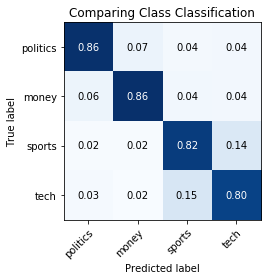

In [73]:
normed_cm(test["label"],predictions)

In [50]:
from sklearn.metrics import confusion_matrix 

In [60]:
#get the confusion matrix:
cm = confusion_matrix(test["label"], predictions)
cm

array([[344,  27,  14,  15],
       [ 20, 285,  13,  12],
       [ 10,  10, 419,  70],
       [ 11,   6,  58, 307]], dtype=int64)

In [62]:
cm[0]/sum(cm[0])

array([0.86  , 0.0675, 0.035 , 0.0375])

In [63]:
normed = []
for row in np.arange(4):
     normed.append(cm[row]/sum(cm[row]))

In [66]:
cm = np.array(normed)

plotting the confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

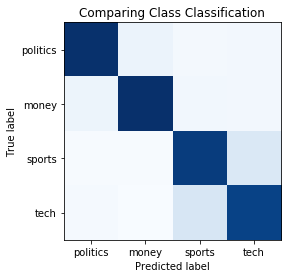

In [67]:
fig, ax = plt.subplots()
classes = ["politics", "money", "sports", "tech"]
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title="Comparing Class Classification",
           ylabel='True label',
           xlabel='Predicted label');